In [1]:
import sys
import plotly.graph_objects as go
sys.path.append("..") 
from orm.mongo_client import FoodMongoClient
import matplotlib.pyplot as plt
import numpy as np
import pprint
from sklearn.decomposition import PCA

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from yellowbrick.text import FreqDistVisualizer
from nltk import word_tokenize
import nltk
nltk.download('punkt')

with FoodMongoClient() as mngcl:
    recipes = mngcl.find_all('recipes')
    ingredients_data = mngcl.find_all('ingredients')
    tags_data = mngcl.find_all('tags')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vadimkozyrevskii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Используются все ингредиенты с частотой, принимающей значения [44, 445]


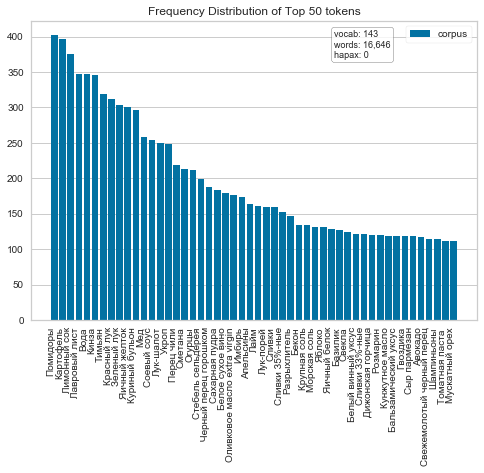

In [3]:
ingredients_k2v = dict([(ingr['id'], ingr['name']) for ingr in ingredients_data])
ingredients = [' '.join(list(map(lambda x: str(x['id']), recipe['ingredients']))) for recipe in recipes]

ingr_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
ingr_docs = ingr_vectorizer.fit_transform(ingredients)

ingr_vocab = list(map(lambda x: x, ingr_vectorizer.get_feature_names()))

ingr_counts = ingr_docs.sum(axis=0).A1
ingr_freq_distribution = Counter(dict(zip(ingr_vocab, ingr_counts)))

ingr_destr = sorted(list(ingr_freq_distribution.items()), key=lambda x : x[1], reverse=True)

lowwer_eps = 0.01
upper_eps = 0.9

print(f'Используются все ингредиенты с частотой, принимающей значения [{round(len(ingredients) * lowwer_eps)}, '
      f'{round(len(ingredients) * (1 - upper_eps))}]')

ingr_destr = [item for item in ingr_destr if item[1] >= round(len(ingredients) * lowwer_eps) and 
                                              item[1] <= round(len(ingredients) * (1 - upper_eps))]

supported_ingr = list(map(lambda x: x[0], ingr_destr))

clear_ingredients = [' '.join(list(map(lambda x: str(x['id']) if str(x['id']) in supported_ingr 
                                                               else '', recipe['ingredients']))) 
                     for recipe in recipes]

ingr_vectorizer = CountVectorizer()
ingr_docs = ingr_vectorizer.fit_transform(clear_ingredients)
ing_features = list(map(lambda x: ingredients_k2v[int(x)], ingr_vectorizer.get_feature_names()))

ingr_vectorizer = FreqDistVisualizer(features=ing_features, orient='v', n=50)
ingr_vectorizer.fit(ingr_docs)
ingr_vectorizer.show()

Используются все теги с частотой, принимающей значения [4, 1334]


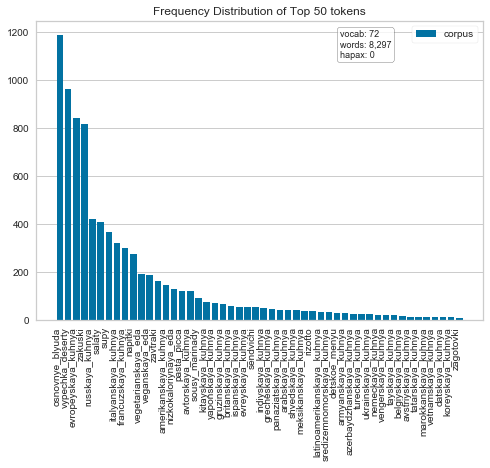

In [4]:
tags_k2v = dict([(tag['id'], tag['name']) for tag in tags_data])
tags = [' '.join(list(map(lambda x: x.replace('-', '_'), recipe['tags']))) for recipe in recipes]

tags_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, ngram_range=(1, 1), min_df=1)
tags_docs = tags_vectorizer.fit_transform(tags)

tags_vocab = list(map(lambda x: x, tags_vectorizer.get_feature_names()))

tags_counts = tags_docs.sum(axis=0).A1
tags_freq_distribution = Counter(dict(zip(tags_vocab, tags_counts)))

tags_destr = sorted(list(tags_freq_distribution.items()), key=lambda x : x[1], reverse=True)

lowwer_eps = 0.001
upper_eps = 0.7

print(f'Используются все теги с частотой, принимающей значения [{round(len(tags) * lowwer_eps)}, '
       f'{round(len(tags) * (1 - upper_eps))}]')

tags_destr = [item for item in tags_destr if item[1] >= round(len(tags) * lowwer_eps) and 
                                              item[1] <= round(len(tags) * (1 - upper_eps))]

supported_tags = list(map(lambda x: x[0], tags_destr))

clear_tags = [' '.join(list(map(lambda x: x.replace('-', '_') if x.replace('-', '_') in supported_tags 
                                else '', recipe['tags']))) 
              for recipe in recipes]

tags_vectorizer = CountVectorizer()
tags_docs = tags_vectorizer.fit_transform(clear_tags)
tags_features = tags_vectorizer.get_feature_names()

tags_vectorizer = FreqDistVisualizer(features=tags_features, orient='v', n=50)
tags_vectorizer.fit(tags_docs)
tags_vectorizer.show()


In [5]:
tags_k2v = {}
ingredients_k2v = {}
dataset = []
with FoodMongoClient() as mngcl:
    tags = mngcl.find_all('tags')
    ingredients = mngcl.find_all('ingredients')
    recepes = mngcl.find_all('recipes')
    recepes_k2v = dict([(rec['id'], rec['name']) for rec in recepes])
    recepes_v2k = dict([(rec['name'], rec['id']) for rec in recepes])
    recipe_ids = []
    for rec in recepes:
        #print(rec['ingredients'])
        #dataset.append(' '.join([str(ing['id']) for ing in rec['ingredients'] if str(ing['id']) in supported_ingr]))
        dataset.append(' '.join([tag for tag in rec['tags'] if tag.replace('-', '_') in supported_tags] +  
                     [str(ing['id']) for ing in rec['ingredients'] if str(ing['id']) in supported_ingr]))
        recipe_ids.append(str(rec['id']))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
X = CountVectorizer().fit_transform(dataset).toarray()

In [108]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import keras

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
original_dim = X.shape[1]
input_shape = (original_dim, )
intermediate_dim = 16
latent_dim = 2

In [109]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 222)          0                                            
__________________________________________________________________________________________________
dense_43 (Dense)                (None, 16)           3568        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_43[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            34          dense_43[0][0]                   
____________________________________________________________________________________________

In [110]:
reconstruction_loss = mse(inputs, outputs)
#reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

opt = keras.optimizers.Adam(lr=0.01)

vae.add_loss(vae_loss)
vae.compile(optimizer=opt)
#vae.summary()
# plot_model(vae,
#            to_file='vae_mlp.png',
#            show_shapes=True)

/Users/vadimkozyrevskii/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning:

Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.



In [111]:
history = vae.fit(X[:3000],
        epochs=100,
        batch_size=128,
        validation_data=(X[3000:], None))

Train on 3000 samples, validate on 1448 samples
Epoch 1/100
3000/3000 [==============================] - 1s 341us/step - loss: 28.7833 - val_loss: 10.8426
Epoch 2/100
3000/3000 [==============================] - 0s 35us/step - loss: 8.7418 - val_loss: 7.0261
Epoch 3/100
3000/3000 [==============================] - 0s 33us/step - loss: 6.9618 - val_loss: 6.2174
Epoch 4/100
3000/3000 [==============================] - 0s 33us/step - loss: 6.3982 - val_loss: 5.8975
Epoch 5/100
3000/3000 [==============================] - 0s 41us/step - loss: 6.2044 - val_loss: 5.7914
Epoch 6/100
3000/3000 [==============================] - 0s 33us/step - loss: 6.1569 - val_loss: 5.7701
Epoch 7/100
3000/3000 [==============================] - 0s 38us/step - loss: 6.1336 - val_loss: 5.7605
Epoch 8/100
3000/3000 [==============================] - 0s 35us/step - loss: 6.1292 - val_loss: 5.7460
Epoch 9/100
3000/3000 [==============================] - 0s 40us/step - loss: 6.1215 - val_loss: 5.7399
Epoch 10/100


3000/3000 [==============================] - 0s 34us/step - loss: 6.0798 - val_loss: 5.6937
Epoch 79/100
3000/3000 [==============================] - 0s 33us/step - loss: 6.0755 - val_loss: 5.6949
Epoch 80/100
3000/3000 [==============================] - 0s 34us/step - loss: 6.0755 - val_loss: 5.7036
Epoch 81/100
3000/3000 [==============================] - 0s 33us/step - loss: 6.0797 - val_loss: 5.7214
Epoch 82/100
3000/3000 [==============================] - 0s 32us/step - loss: 6.0763 - val_loss: 5.7010
Epoch 83/100
3000/3000 [==============================] - 0s 37us/step - loss: 6.0750 - val_loss: 5.7051
Epoch 84/100
3000/3000 [==============================] - 0s 36us/step - loss: 6.0735 - val_loss: 5.7150
Epoch 85/100
3000/3000 [==============================] - 0s 31us/step - loss: 6.0777 - val_loss: 5.7083
Epoch 86/100
3000/3000 [==============================] - 0s 36us/step - loss: 6.0746 - val_loss: 5.7008
Epoch 87/100
3000/3000 [==============================] - 0s 27us/st

dict_keys(['val_loss', 'loss'])


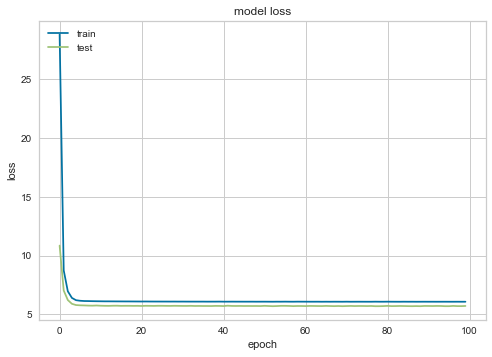

In [112]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [100]:
# [np.array(list(map(lambda x: 1 if x>0.35 else 0, item))) for item in vae.predict(X[-2:])]

In [101]:
# X[-2:]

In [125]:
#list(map(sampling, list(map(lambda x: (x[0], x[1]), encoder.predict(X)))))

In [80]:
recipe_vectors = encoder.predict(X)[2]
print(recipe_vectors.shape)
recipe_pca_vectors = PCA(n_components=2).fit_transform(recipe_vectors)
fig = go.Figure(data=go.Scatter(x=recipe_pca_vectors[:, 0],
                        y=recipe_pca_vectors[:, 1],
                        mode='markers',
                        text=list(map(lambda x: recepes_k2v[x], recipe_ids)))) # hover text goes here
fig.update_layout(title=f'Recipes')
fig.show()

(4448, 64)


In [81]:
tree_id2rec_key = dict([(i, recipe) for i, recipe in enumerate(recipe_ids)])
rec_key2tree_id = dict([(recipe, i) for i, recipe in enumerate(recipe_ids)])

rec_name2tree_id = dict([(recepes_k2v[recipe], i) for i, recipe in enumerate(recipe_ids)])
tree_id2rec_name = dict([(i, recepes_k2v[recipe]) for i, recipe in enumerate(recipe_ids)])

In [84]:
from sklearn.cluster import DBSCAN

recipe_names = [
    'Долма',
    'Хинкали',
    'Торт «Красный бархат» от\xa0Andy Chef',
    'Традиционный торт «Наполеон»',
    'Торт «Прага»',
    'Торт «Сметанник»',
    'Торт «Муравейник»',
    'Пицца «Маргарита» Вальтера Бизоффи',
    'Чикагская пицца'
]

#list(rec_name2tree_id.keys())[:100]

vectors = list(map(lambda x: encoder.predict(X)[2][rec_name2tree_id[x]], recipe_names))

from sklearn.cluster import DBSCAN
import pprint
clustering = DBSCAN(eps=0.1, min_samples=2).fit(vectors)
clusters_set = set(clustering.labels_)

#pprint.pprint(sorted(list(zip(recipe_names, clustering.labels_)), key=lambda x: x[1]))

data_for_recomendations = dict(zip(clusters_set, [
    [rec for i, rec in enumerate(recipe_names) if clustering.labels_[i] == label] for label in clusters_set]))

pprint.pprint(data_for_recomendations)

{-1: ['Долма',
      'Хинкали',
      'Торт «Красный бархат» от\xa0Andy Chef',
      'Традиционный торт «Наполеон»',
      'Торт «Прага»',
      'Торт «Сметанник»',
      'Торт «Муравейник»',
      'Пицца «Маргарита» Вальтера Бизоффи',
      'Чикагская пицца']}


In [86]:
from sklearn.neighbors import KDTree
from operator import itemgetter
tree = KDTree(recipe_vectors, leaf_size=2)

recomendations = {}

for label, names in data_for_recomendations.items():
    if label == -1: continue
    
    
    dist, ind = tree.query(
        [
            np.mean(
                list(map(lambda x: recipe_vectors[rec_name2tree_id[x]], names))
                , axis=0)
        ], k=20)
    
    keys = itemgetter(*ind[0])(tree_id2rec_key)
    values = itemgetter(*ind[0])(tree_id2rec_name)
    
    recomendations[label] = list(zip(keys, values))
    

pprint.pprint(recomendations)

{}
